In [ ]:
!pip install pandas numpy matplotlib tensorflow scikit-learn statsmodels plotly

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


import tensorflow as tf
import os
from tensorflow.keras import layers, models
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 13.6 MB/s eta 0:00:00


In [ ]:
data = pd.read_csv(r"/ngpf_data.csv")
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6321 entries, 0 to 6320
Data columns (total 2 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Day                               6321 non-null   object 
 1   Price in Dollars per Million Btu  6320 non-null   float64
dtypes: float64(1), object(1)
memory usage: 98.9+ KB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Renaming columns
data = data.rename({'Day': 'date', 'Price in Dollars per Million Btu': 'gas_price'}, axis = 1)

# Setting Date as index
data = data.set_index('date')

In [ ]:
data.tail(3)

,gas_price
date,
9/1/1997,3.61
8/1/1997,3.80
7/1/1997,3.82


In [ ]:
print(data.isnull().sum())

gas_price    1
dtype: int64


In [ ]:
# There is one missing value in the data, we fill it with previous day's price.

data = data.fillna(method = 'pad')
print(data.isnull().sum())

gas_price    0
dtype: int64


In [ ]:
import plotly.express as px

fig = px.line(data, title = 'Natural Gas Spot Prices', template = 'plotly_dark')
fig.show()

In [ ]:
fig = px.histogram(data, x = "gas_price", template = 'plotly_dark')
fig.show()

In [ ]:
def test_stationarity(timeseries):

    # Determing rolling statistics
    rolmean = timeseries.rolling(25).mean()
    rolstd = timeseries.rolling(25).std()

    # Plot rolling statistics:
    plt.figure(figsize = (20,10))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

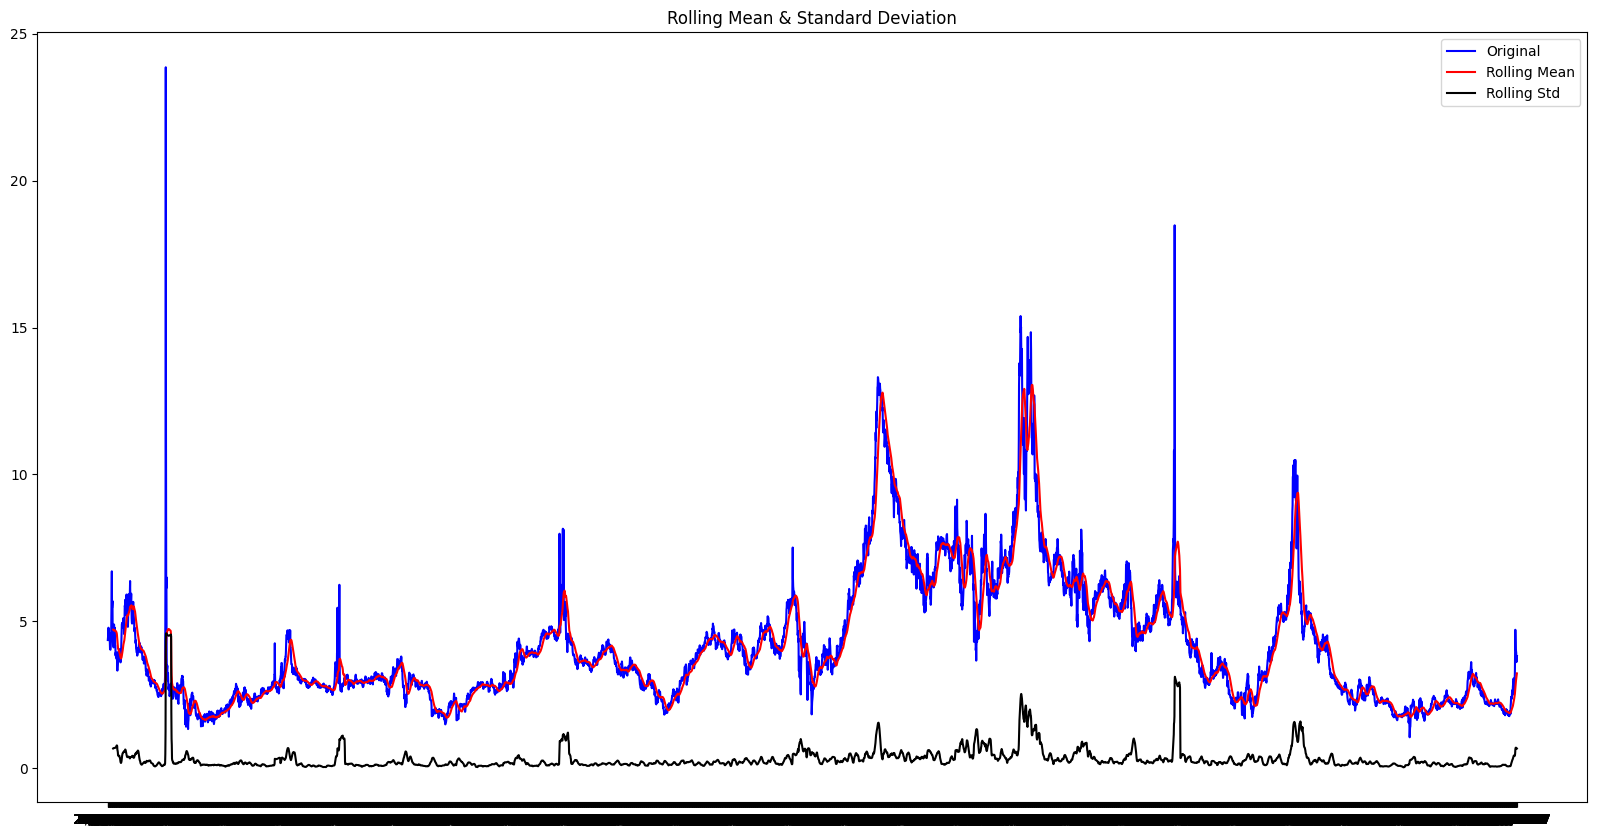

Results of Dickey-Fuller Test:
Test Statistic                   -3.867920
p-value                           0.002284
#Lags Used                        8.000000
Number of Observations Used    6312.000000
Critical Value (1%)              -3.431386
Critical Value (5%)              -2.861998
Critical Value (10%)             -2.567014
dtype: float64


In [ ]:
test_stationarity(data)

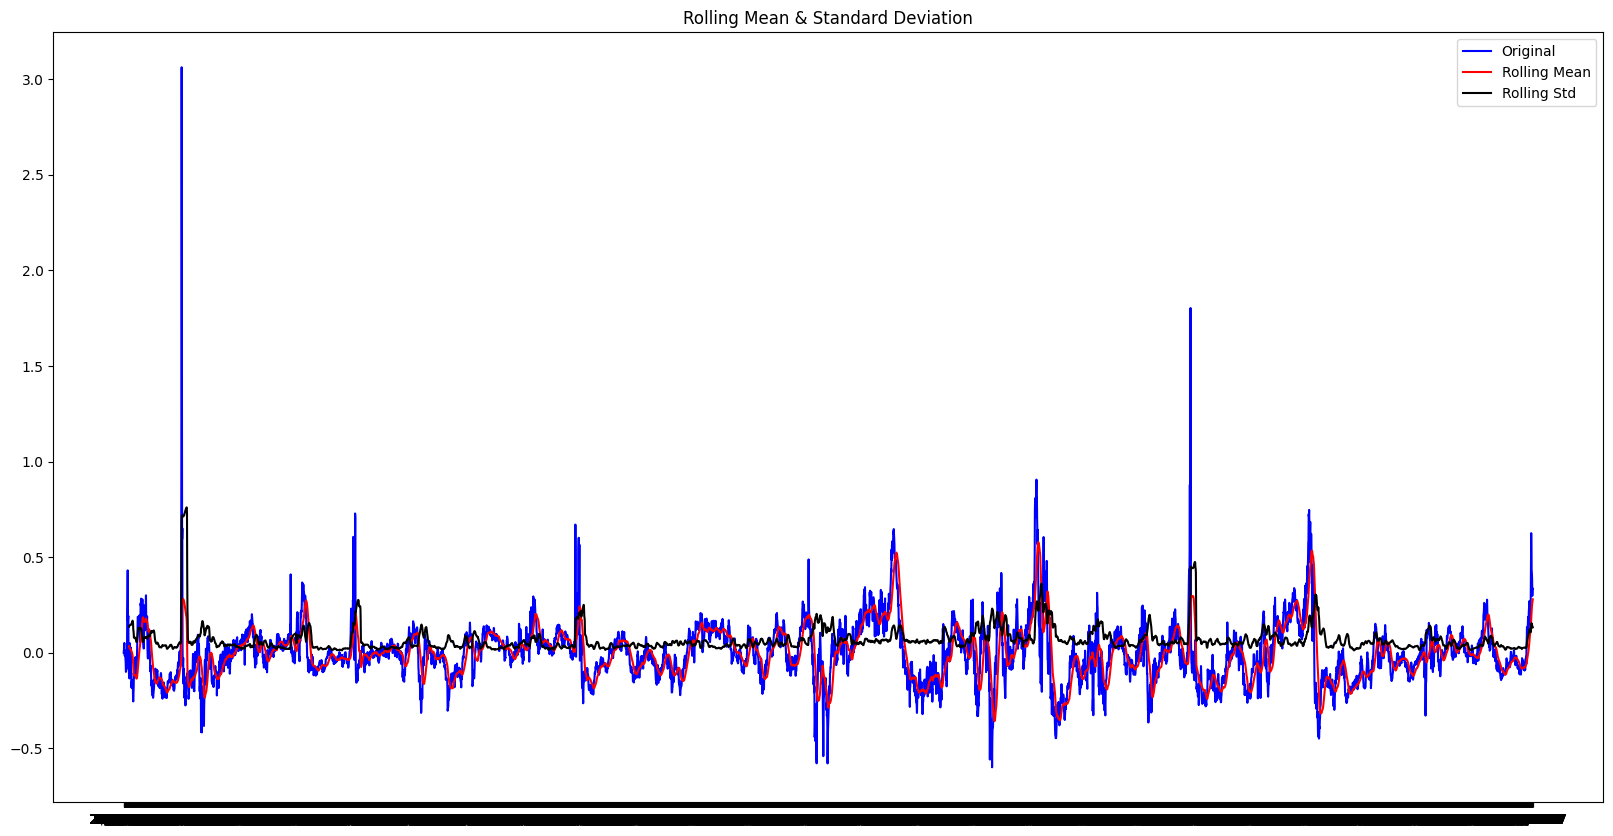

Results of Dickey-Fuller Test:
Test Statistic                -1.125358e+01
p-value                        1.688509e-20
#Lags Used                     1.000000e+01
Number of Observations Used    6.310000e+03
Critical Value (1%)           -3.431387e+00
Critical Value (5%)           -2.861998e+00
Critical Value (10%)          -2.567014e+00
dtype: float64


In [ ]:
ts_sqrt = np.sqrt(data)
expwighted_avg = ts_sqrt.ewm(halflife = 25).mean()

ts_sqrt_ewma_diff = ts_sqrt - expwighted_avg
test_stationarity(ts_sqrt_ewma_diff)

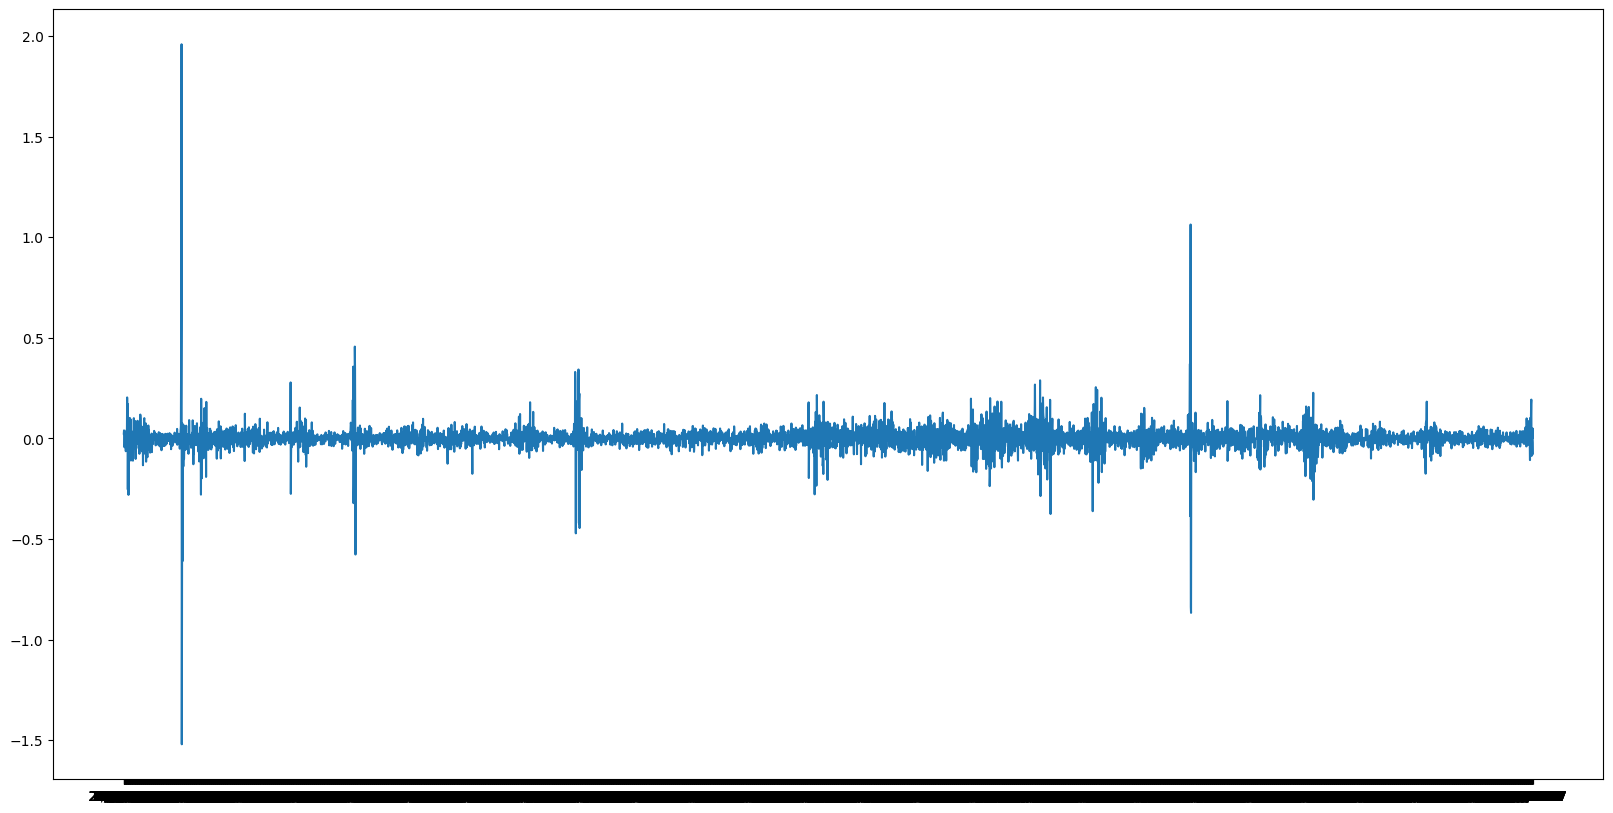

In [ ]:
ts_sqrt_diff = ts_sqrt - ts_sqrt.shift()

plt.figure(figsize = (20,10))
plt.plot(ts_sqrt_diff)
plt.show()

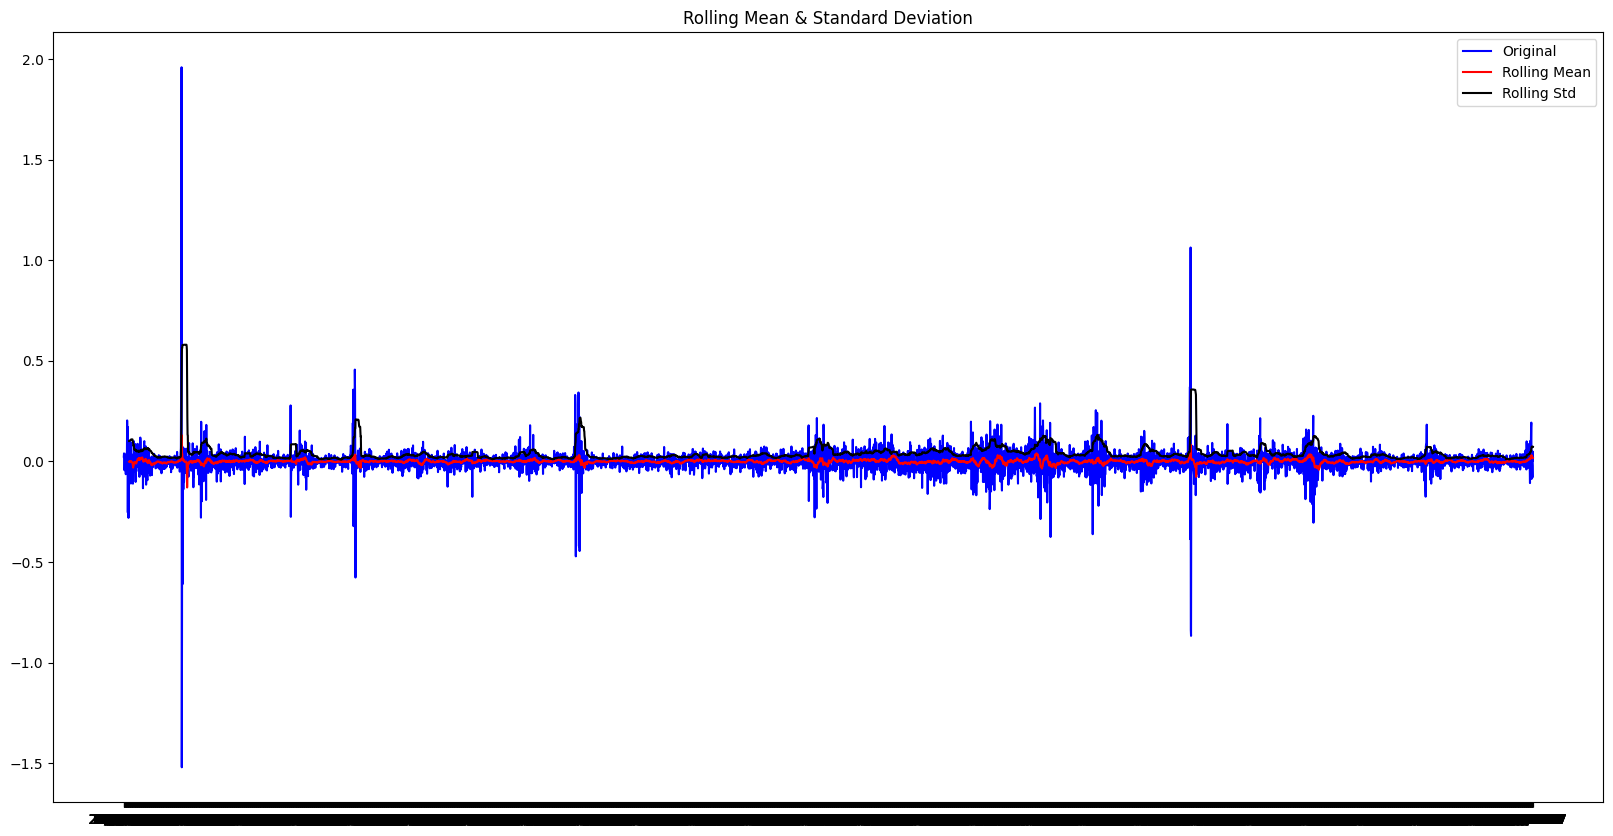

Results of Dickey-Fuller Test:
Test Statistic                  -25.917790
p-value                           0.000000
#Lags Used                       11.000000
Number of Observations Used    6308.000000
Critical Value (1%)              -3.431387
Critical Value (5%)              -2.861998
Critical Value (10%)             -2.567014
dtype: float64


In [ ]:
ts_sqrt = np.sqrt(data)
ts_sqrt_diff = ts_sqrt - ts_sqrt.shift()
ts_sqrt_diff.dropna(inplace = True)
test_stationarity(ts_sqrt_diff)

In [ ]:
data = data.sort_values(by = 'date')

train = data['1997-01-06': '2020-01-06'] # 7 Jan 1997 to 6 Jan 2021
test = data['2020-01-07': '2022-03-01'] # 7 Jan 2021  to 1 Mar 2022

print("Length of Train Data: ", len(train))
print("Length of Test Data: ", len(test))

Length of Train Data:  415
Length of Test Data:  0


In [ ]:
train.head(2)

,gas_price
date,
2/1/1998,2.16
2/1/2001,9.97


In [ ]:
train.tail(2)

,gas_price
date,
20/9/2019,2.34
20/9/2021,5.25


In [ ]:
test.head(2)

,gas_price
date,


In [ ]:
test.tail(2)

,gas_price
date,


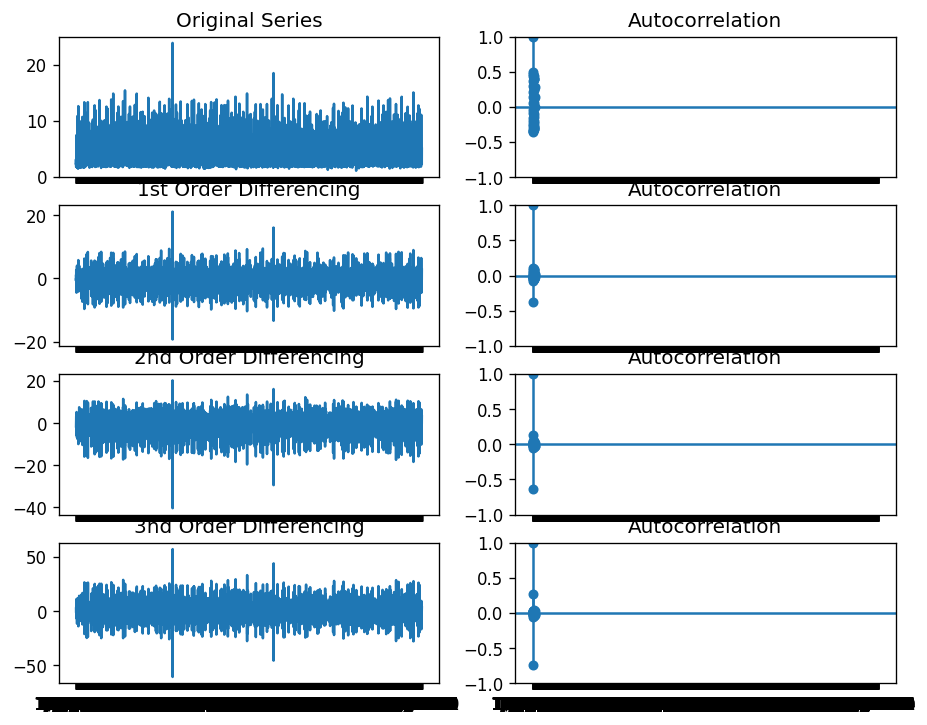

In [ ]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(4, 2, sharex=True)
axes[0, 0].plot(data.gas_price); axes[0, 0].set_title('Original Series')
plot_acf(data.gas_price, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data.gas_price.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data.gas_price.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data.gas_price.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data.gas_price.diff().diff().dropna(), ax=axes[2, 1])

# 3rd Differencing
axes[3, 0].plot(data.gas_price.diff().diff().diff()); axes[3, 0].set_title('3nd Order Differencing')
plot_acf(data.gas_price.diff().diff().diff().dropna(), ax=axes[3, 1])

plt.show()

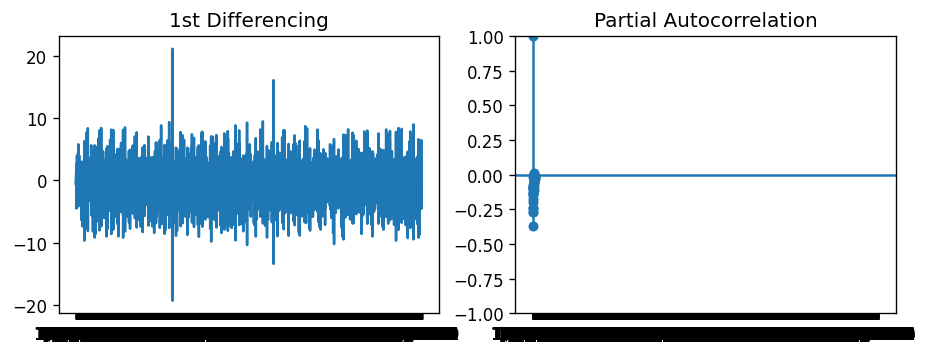

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data.gas_price.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(data.gas_price.diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
model = sm.tsa.arima.ARIMA(train, order = (1, 2, 1))
arima_model = model.fit()
print(arima_model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.



                               SARIMAX Results                                
Dep. Variable:              gas_price   No. Observations:                  415
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -907.243
Date:                Fri, 27 Sep 2024   AIC                           1820.486
Time:                        20:12:44   BIC                           1832.557
Sample:                             0   HQIC                          1825.260
                                - 415                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3359      0.036     -9.202      0.000      -0.407      -0.264
ma.L1         -0.9998      1.168     -0.856      0.392      -3.289       1.290
sigma2         4.6616      5.393      0.864      0.3

In [ ]:
yp_train = arima_model.predict(start = 0, end = (len(train)-1))
yp_test = arima_model.predict(start = 0, end = (len(test)-1))

print("Train Data:\nMean Square Error: {}".format(mean_squared_error(train, yp_train)))
print("\nTest Data:\nMean Square Error: {}".format(mean_squared_error(test, yp_test)))

Train Data:
Mean Square Error: 4.542123860038174

Test Data:
Mean Square Error: 6.260522748409283


In [ ]:
print(yp_test)

date
2016-01-01    0.000000
1997-10-01    3.419997
1998-10-01    3.880010
1999-10-01    2.642258
2001-10-01    2.299456
                ...   
2016-09-14    2.789242
2017-09-14    2.933371
2018-09-14    3.045413
2020-09-14    2.954957
2021-09-14    2.450436
Name: predicted_mean, Length: 1265, dtype: float64


In [ ]:
print(test)

            gas_price
date                 
2007-08-31       5.49
2009-08-31       2.42
2010-08-31       3.80
2011-08-31       3.97
2012-08-31       2.72
...               ...
2015-09-09       2.74
2016-09-09       2.93
2019-09-09       2.65
2020-09-09       2.21
2021-09-09       4.97

[1265 rows x 1 columns]


In [ ]:
print(train)

            gas_price
date                 
2016-01-01       2.28
1997-10-01       3.08
1998-10-01       2.33
1999-10-01       2.39
2001-10-01       1.74
...               ...
2000-08-31       4.76
2001-08-31       2.15
2004-08-31       5.04
2005-08-31      12.69
2006-08-31       5.80

[5056 rows x 1 columns]


In [ ]:
slot = 15

x_train = []
y_train = []

for i in range(slot, len(train)):
    x_train.append(train.iloc[i-slot:i, 0])
    y_train.append(train.iloc[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape, y_train.shape)

(5041, 15, 1) (5041,)


In [ ]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(units = 50, input_shape = (slot, 1), return_sequences = True, activation = 'relu'))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.LSTM(units = 50, activation = 'relu', return_sequences = True))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.LSTM(units = 50, return_sequences = False))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.Dense(units = 1))
lstm_model.compile(loss = 'mean_squared_error', optimizer = 'adam')

lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 15, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 15, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 15, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 7)

history = lstm_model.fit(x_train, y_train, epochs = 100,
                         batch_size = 64,
                         verbose = 1, shuffle = False,
                         callbacks = [early_stopping])

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 9.9020 
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.8640
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.6622
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.5696
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 2.5578
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 2.5395
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 2.5541
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 2.5081
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.4785
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.3927
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 2.3525
Epoch 12/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.3277
Epoch 13/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 2.2696
Epoch 14/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.2583
Epoch 15/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - l

In [ ]:
yp_train = lstm_model.predict(x_train)
a = pd.DataFrame(yp_train)
a.rename(columns = {0: 'gp_pred'}, inplace = True);
a.index = train.iloc[slot:].index
train_compare = pd.concat([train.iloc[slot:], a], axis=1)

158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
train_compare.head(3)

,gas_price,gp_pred
date,,
2015-10-01,2.37,2.508736
2018-10-01,3.13,2.628300
2019-10-01,2.36,2.350960


In [ ]:
train_compare.tail(3)

,gas_price,gp_pred
date,,
2004-08-31,5.04,6.100988
2005-08-31,12.69,12.275444
2006-08-31,5.80,6.530262


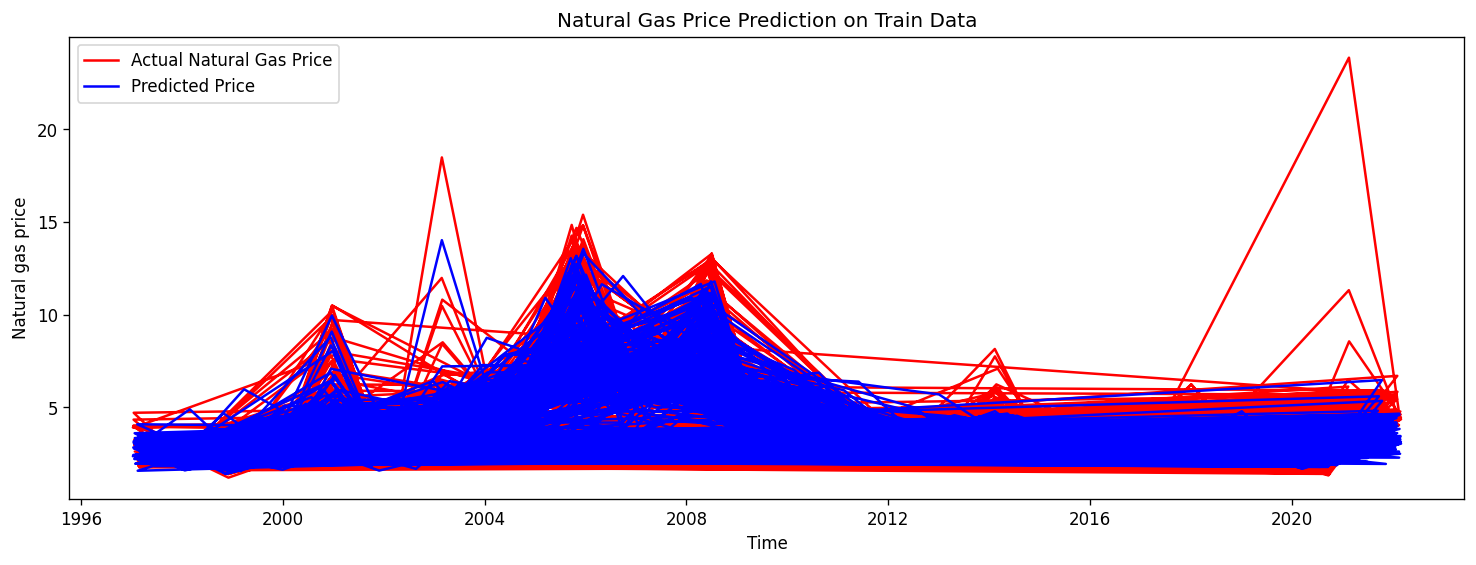

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(train_compare['gas_price'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(train_compare['gp_pred'], color = 'blue', label = 'Predicted Price')
plt.title("Natural Gas Price Prediction on Train Data")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()

In [ ]:
dataset_total = pd.concat((train, test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test)- slot:].values
inputs = inputs.reshape(-1, 1)

x_test = []
y_test = []
for i in range (slot, len(test)+slot): #Test+15
    x_test.append(inputs[i-slot:i, 0])
    y_test.append(train.iloc[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
pred_price = lstm_model.predict(x_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
b = pd.DataFrame(pred_price)
b.rename(columns = {0: 'gp_pred'}, inplace = True);
b.index = test.index
test_compare = pd.concat([test, b], axis=1)

In [ ]:
test_compare.head(3)

,gas_price,gp_pred
date,,
2007-08-31,5.49,6.656275
2009-08-31,2.42,3.682343
2010-08-31,3.80,3.977609


In [ ]:
test_compare.tail(3)

,gas_price,gp_pred
date,,
2019-09-09,2.65,2.485309
2020-09-09,2.21,2.178572
2021-09-09,4.97,2.997048


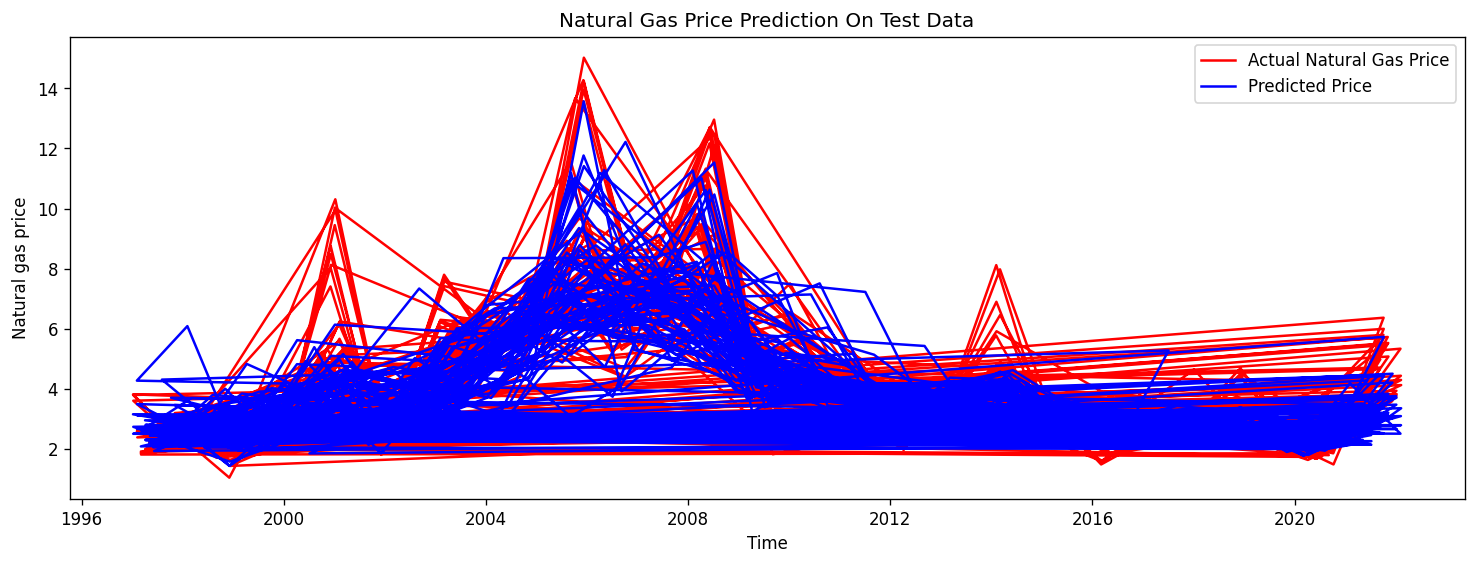

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(test_compare['gas_price'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(test_compare['gp_pred'], color = 'blue', label = 'Predicted Price')
plt.title("Natural Gas Price Prediction On Test Data")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()

In [ ]:
mse_train = mean_squared_error(train_compare['gas_price'], train_compare['gp_pred'])
mse_test = mean_squared_error(test_compare['gas_price'], test_compare['gp_pred'])

r2_train = r2_score(train_compare['gas_price'], train_compare['gp_pred'])
r2_test = r2_score(test_compare['gas_price'], test_compare['gp_pred'])

print("Train Data:\nMSE: {}\nR Square: {}".format(mse_train, r2_train))
print("\nTest Data:\nMSE: {}\nR Square: {}".format(mse_test, r2_test))

Train Data:
MSE: 1.1420146807526674
R Square: 0.7582454716790805

Test Data:
MSE: 1.5872929948850745
R Square: 0.6505480735757586


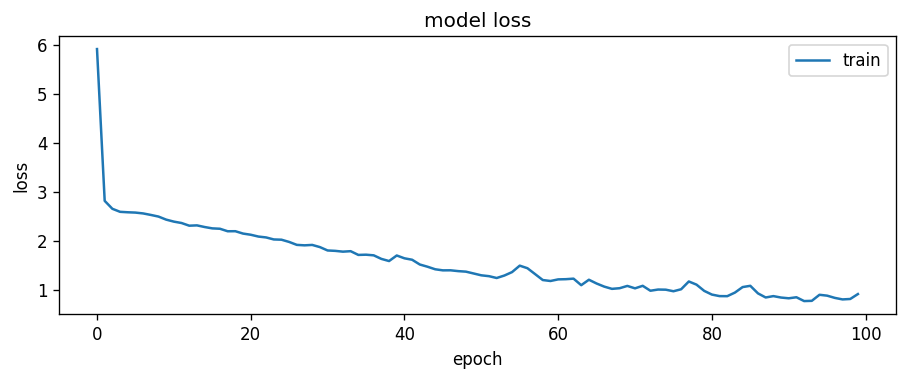

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [ ]:
forecast = pd.DataFrame({'date': pd.date_range(start = '3/2/2022', end = '3/20/2022')}) # 2 March to 20 March

inputs = test[len(test) - slot: ].values

for i in range(slot, len(forecast)):
    inputs = inputs.T
    inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1], 1))
    pred_price = lstm_model.predict(inputs[:,i-slot:i])
    inputs = np.append(inputs, pred_price)
    inputs = np.reshape(inputs, (inputs.shape[0], 1))

forecast['gp_pred'] = inputs
forecast = forecast.set_index('date')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [ ]:
forecast.reset_index(inplace = True)

fig = px.line(forecast, x = "date", y = "gp_pred", title = 'Natural Gas Price Forecasting', template = 'plotly_dark')
fig.show()

In [ ]:
train_compare.reset_index(inplace = True)
test_compare.reset_index(inplace = True)

df = pd.concat((train_compare[['date','gp_pred']], test_compare[['date', 'gp_pred']], forecast[['date', 'gp_pred']]), axis = 0)

In [ ]:
df.head(3)

,date,gp_pred
0,2015-10-01,2.508736
1,2018-10-01,2.628300
2,2019-10-01,2.350960


In [ ]:
df.tail(3)

,date,gp_pred
16,2022-03-18,3.584507
17,2022-03-19,4.119570
18,2022-03-20,2.910048


In [ ]:
df.to_csv("predicted_price.csv", index = False)
lstm_model.save("lstm_model.h5")